In [1]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #

cpu


In [3]:
base_path = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\disease-grading-custom"

In [4]:
train_df = pd.read_csv(os.path.join(base_path,"groundtruths", "idrid-train.csv"))
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(os.path.join(base_path,"groundtruths", "idrid-test.csv"))
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 413
No.of.testing_samples: 102


<Axes: xlabel='diagnosis'>

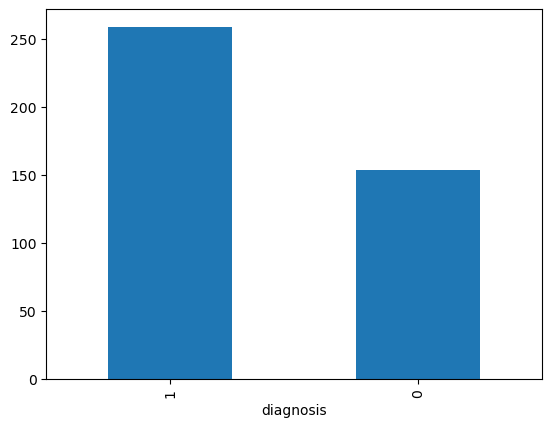

In [5]:
train_df['diagnosis'].value_counts().plot(kind='bar')



### Balancing the dataset

In [6]:
from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights)

tensor([1.3409, 0.7973])


### Dataset

In [7]:
class CustomDataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['Image name'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [8]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 

In [9]:
#Transformations to apply to the image.
data_set = CustomDataset(train_df,os.path.join(base_path, 'final-training'),image_transform=image_transform)
print(f'No.of.samples in the dataset: {len(data_set)}')
#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
split_ratio = 0.2
train_num = int(len(data_set)*(1-split_ratio))
valid_num = len(data_set) - train_num
print(f'No.of.samples in the training_set: {train_num}')

train_set,valid_set = torch.utils.data.random_split(data_set,[train_num,valid_num])

No.of.samples in the dataset: 413
No.of.samples in the training_set: 330


In [10]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=8,shuffle=False) 

In [11]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1) #Downloads the resnet34 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet34 with 4 new layers.
model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(inplace=True),
                         nn.Linear(256,128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128,64),
                         nn.ReLU(inplace=True),
                         nn.Linear(64,2),    
                    )

In [12]:
model = model.to(device)

### Training and Validations
Helper functions for training and validation

In [13]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [14]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

### Optimizing the model

In [15]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

### Train the model

In [16]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 60
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)



Epoch 1/60
-------------------------------



Training Loss = 0.692976	Accuracy on Training set = 38.181818% [126/330]

Validation Loss = 0.693450	Accuracy on Validation set = 36.144578% [30/83]

Epoch 2/60
-------------------------------

Training Loss = 0.692990	Accuracy on Training set = 38.181818% [126/330]

Validation Loss = 0.693504	Accuracy on Validation set = 34.939759% [29/83]

Epoch 3/60
-------------------------------

Training Loss = 0.694222	Accuracy on Training set = 39.090909% [129/330]

Validation Loss = 0.693797	Accuracy on Validation set = 37.349398% [31/83]

Epoch 4/60
-------------------------------

Training Loss = 0.692965	Accuracy on Training set = 38.484848% [127/330]

Validation Loss = 0.693939	Accuracy on Validation set = 37.349398% [31/83]

Epoch 5/60
-------------------------------

Training Loss = 0.691739	Accuracy on Training set = 38.787879% [128/330]

Validation Loss = 0.693139	Accuracy on Validation set = 37.349398% [31/83]

Epoch 6/60
-------------------------------

Training Loss = 0.691575	Accu

### Save or load the model

In [23]:
base_path_model_save = "C:\\Users\\hsr30\\Documents\\minor-project\\disease-grading\\models"


In [17]:
# Save
num_model = len(os.listdir(base_path_model_save))
torch.save(model.state_dict(), os.path.join(base_path_model_save, f"{num_model}-resnet34-tl.pth"))

### Load the model

In [16]:
# Load
model_name = '8-resnet34-tl.pth'
model.load_state_dict(torch.load(os.path.join(base_path_model_save, model_name), map_location=torch.device(device)))

NameError: name 'base_path_model_save' is not defined

### Post training analysis

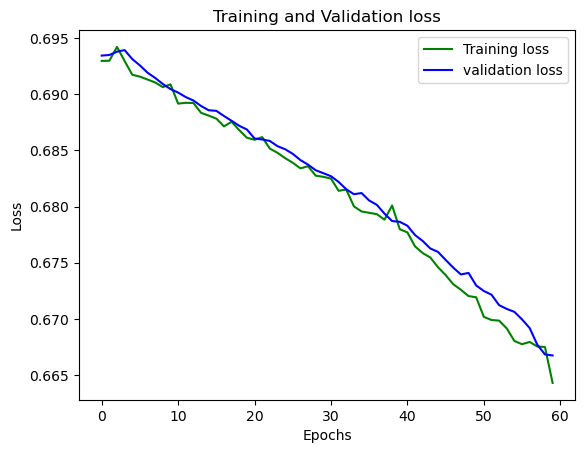

In [18]:
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing

In [17]:
def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.
    
    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         
    Returns :
         List of predicted labels.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.
    
    with torch.no_grad():
        
        for batch,x in enumerate(dataloader):
            
            output = model(x.to(device))
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)
                
    print('Testing has completed')
            
    return labels 

In [31]:
test_set = CustomDataset(test_df,os.path.join(base_path, 'final-testing'),image_transform = image_transform, train = False )

test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False) #DataLoader for test_set.

In [32]:
labels = test(test_dataloader,model)
# accuracy
correct = 0
total = 0
for i in range(len(labels)):
    if labels[i] == test_df['diagnosis'][i]:
        correct += 1
    total += 1
print(f'Accuracy on test set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.   


Testing has completed
Accuracy on test set = 66.666667% [68/102]


[[20 19]
 [15 48]]


c:\Users\hsr30\.conda\envs\deeplearning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hsr30\.conda\envs\deeplearning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hsr30\.conda\envs\deeplearning\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hsr30\.conda\envs\deeplearning\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

<Axes: >

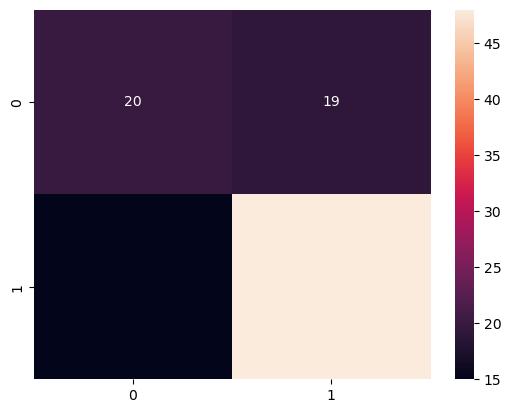

In [34]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_df['diagnosis'], labels)
print(cm)
sns.heatmap(cm, annot=True, fmt="d")


### Predict individual images

In [43]:
image_path =  "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\random-data\\15_left.jpeg"
image = Image.open(image_path)
image = image_transform(image)
image = image.unsqueeze(0)
output = model(image.to(device))
prediction = output.argmax(dim=1).cpu().detach().tolist()
print(prediction)

[0]
